# 入门讲座示例代码

首先我们使用Pip安装必要的python包（如果尚未安装）

In [1]:
!pip install --user -r requirements.txt

我们导入必要的包以及为竞赛提供的辅助函数

In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from wettbewerb import load_references, get_3montages
import mne
from scipy import signal as sig
import ruptures as rpt

在我们的情况下，训练数据文件夹位于git仓库上一级的文件夹中。对于此示例，我们只加载训练数据的一个小子集。

In [ ]:
training_folder = "./shared_data/training_mini"

导入EEG文件，包含名称(id)、通道标识(channels)、采样频率(Hz)、参考系统和相关诊断(seizure_present, onset, offset)。（通常fs=256 Hz）

In [4]:
# 加载参考数据
ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(training_folder) 

100	 个文件已加载。


In [15]:
idx_record = 93
print("IDs[0:3]: ",ids[:3])
print("可用通道:",channels[idx_record])
print("采样率: ", sampling_frequencies[idx_record],"Hz")
print("参考系统: ", reference_systems[idx_record])
print("EEG标签: (seizure_present, onset, offset)", eeg_labels[idx_record])

IDs[0:3]:  ['aaaaaaac_s001_t000', 'aaaaaaac_s001_t001', 'aaaaaaac_s002_t000']
可用通道: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
采样率:  400 Hz
参考系统:  AR
EEG标签: (seizure_present, onset, offset) (1, 34.8275, 63.0425)


In [16]:
# 计算第一个记录左右大脑半球的导联
new_montage, new_data, is_missing = get_3montages(channels[idx_record], data[idx_record])
print("所有导联都已计算: ", not is_missing)
print("导联: ",new_montage)
print("信号维度: ", new_data.shape)

所有导联都已计算:  True
导联:  ['Fp1-F3', 'Fp2-F4', 'C3-P3']
信号维度:  (3, 106000)


我们查看三个导联

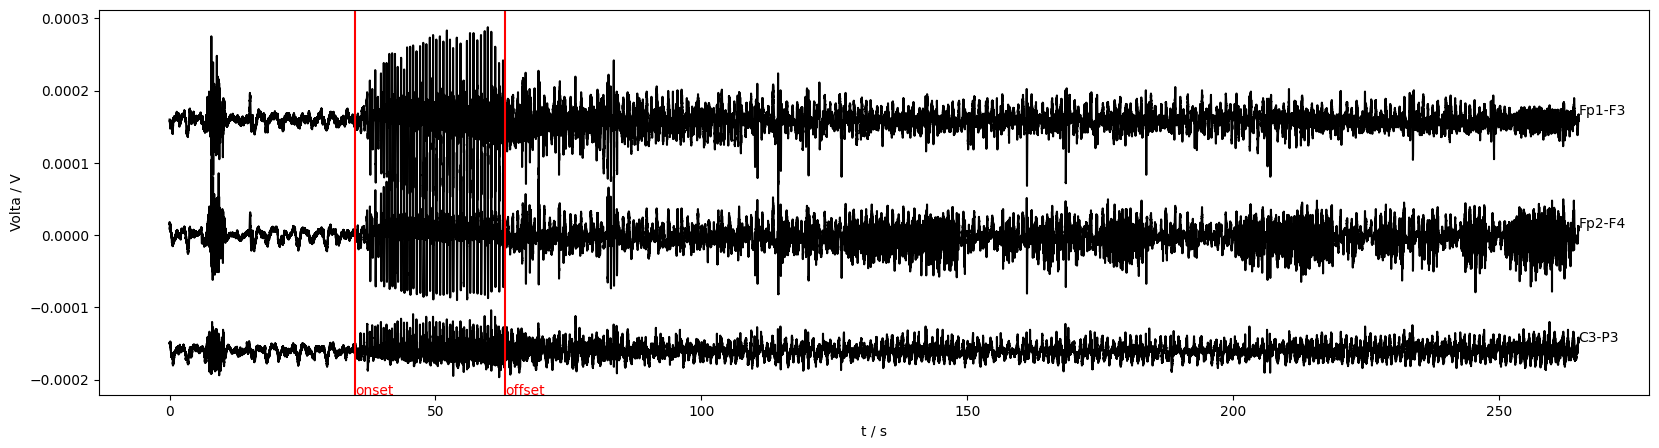

In [20]:
fig, axs = plt.subplots(figsize=[20,5])
max_diff=new_data.max()-new_data.min()
time_ax = np.arange(new_data.shape[1])/sampling_frequencies[idx_record]
_off_sets = [max_diff/1.5,0,-max_diff/1.5]
_labels = eeg_labels[idx_record]

for i, _montage in enumerate(new_montage):
    plt.plot(time_ax,new_data[i,:]+_off_sets[i],'k')
    plt.text(time_ax[-1], new_data[i,-1]+_off_sets[i], _montage)
if _labels[0]:
    plt.axvline(x = _labels[1], color = 'r', label = 'onset')
    plt.text(_labels[1], axs.get_ylim()[0], 'onset',color='r')  
    plt.axvline(x = _labels[2], color = 'r', label = 'offset')
    plt.text(_labels[2], axs.get_ylim()[0], 'offset',color='r')   
plt.xlabel("t / s")
plt.ylabel("Volta / V")
plt.show()

## 确定癫痫发作的起始点
竞赛的核心目标是确定癫痫发作的起始点。在下面的实现中，我们不使用机器学习，而是基于简单的考虑和信号处理来确定。在某些情况下可以取得非常好的结果，但也有一些情况下这种方法不起作用。解决这个问题是你们在竞赛过程中的任务。

In [8]:
onset_list_predict = []
onset_list = []
seizure_id_list = []

for i,_id in enumerate(ids):
    _fs = sampling_frequencies[i]
    _eeg_signals = data[i]
    _eeg_label = eeg_labels[i]
    if _eeg_label[0]:
        onset_list.append(_eeg_label[1])
        seizure_id_list.append(_id)
        # 计算导联
        _montage, _montage_data, _is_missing = get_3montages(channels[i], _eeg_signals)
        for j, signal_name in enumerate(_montage):
            # 提取EEG的第一个导联
            signal = _montage_data[j]
            # 应用陷波滤波器来抑制工频噪声
            signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
            # 应用0.5Hz到70Hz的带通滤波器来过滤信号中的噪声
            signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
            
            # 计算信号的短时傅里叶变换：signal_filtered = 通道的滤波信号, fs = 采样频率, nperseg = 每段长度
            # 输出 f= 采样频率数组, t = 段时间数组, Zxx = 信号的STFT
            f, t, Zxx = sig.stft(signal_filter, _fs, nperseg=_fs * 3)
            # 计算频率步长
            df = f[1] - f[0]
            # 基于STFT的实部和虚部计算能量（幅值）
            E_Zxx = np.sum(Zxx.real ** 2 + Zxx.imag ** 2, axis=0) * df

            # 在每个患者的第一次迭代中创建新数组
            if j == 0:
                # 用第一个通道的能量信号初始化数组
                E_array = np.array(E_Zxx)
            else:
                # 将新的能量信号添加到现有通道中（堆叠）
                E_array = np.vstack((E_array, np.array(E_Zxx)))

        # 计算所有通道在每个时间点的总能量
        E_total = np.sum(E_array, axis=0)
        # 计算最大能量的位置
        max_index = E_total.argmax()

        # 计算总能量的"变化点"
        # 如果最大值在信号开始处，起始点也必须在开始处，我们无法计算"变化点"
        if max_index == 0:
            onset_list_predict.append(0.0)
        else:
            # 使用ruptures包计算"变化点"
            # 设置"线性惩罚分割方法"来检测信号中的变化点，使用rbf代价函数
            algo = rpt.Pelt(model="rbf").fit(E_total)
            # 计算排序的变化点列表，pen = 惩罚值
            result = algo.predict(pen=10)
            # 索引偏移1
            result1 = np.asarray(result) - 1
            # 选择最大值之前的变化点
            result_red = result1[result1 < max_index]
            # 如果至少有一个变化点，我们取最接近最大值的那个
            if len(result_red)<1:
                # 如果没有找到变化点，我们猜测它"接近"最大值
                print('没有找到变化点，取最大值')
                onset_index = max_index
            else:
                # 变化点对应起始点
                onset_index = result_red[-1]
            # 将起始点添加到起始点列表中
            onset_list_predict.append(t[onset_index])

没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值
没有找到变化点，取最大值


我们基于导联查看结果

c:\Users\lvxiangyu11\anaconda3\envs\eeg\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\lvxiangyu11\anaconda3\envs\eeg\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\lvxiangyu11\anaconda3\envs\eeg\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


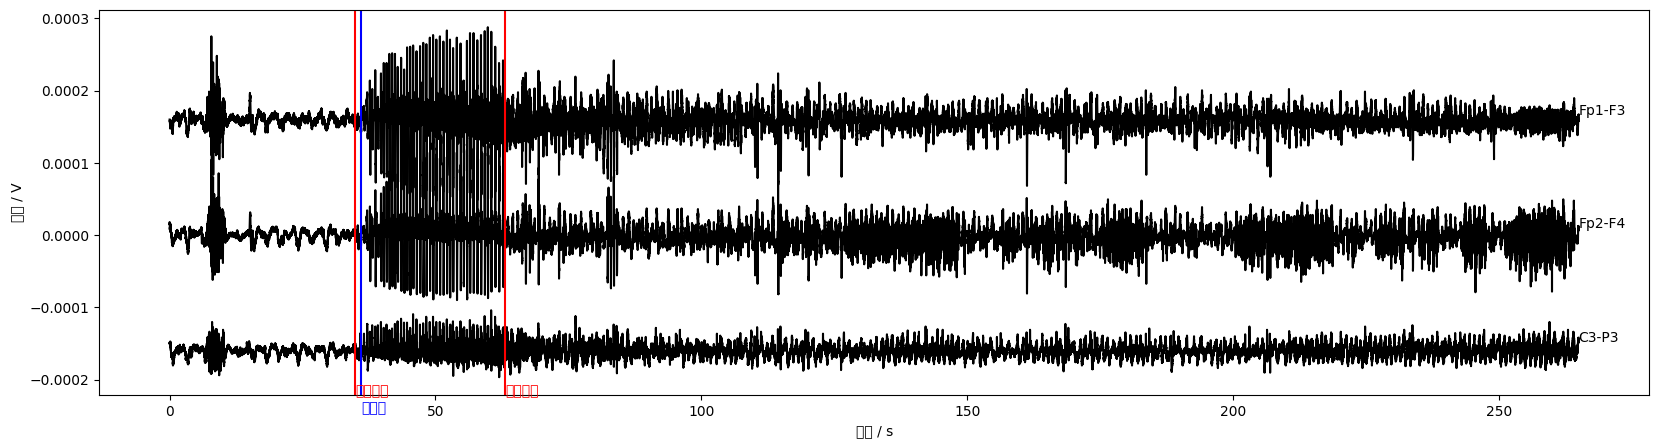

In [9]:
fig,axs = plt.subplots(figsize=[20,5])
max_diff=new_data.max()-new_data.min()
time_ax = np.arange(new_data.shape[1])/sampling_frequencies[idx_record]
_off_sets = [max_diff/1.5,0,-max_diff/1.5]
_labels = eeg_labels[idx_record]

for i, _montage in enumerate(new_montage):
    plt.plot(time_ax,new_data[i,:]+_off_sets[i],'k')
    plt.text(time_ax[-1], new_data[i,-1]+_off_sets[i], _montage)
if _labels[0]:
    pred_idx = seizure_id_list.index(ids[idx_record])
    plt.axvline(x = _labels[1], color = 'r', label = '发作起始')
    plt.text(_labels[1], axs.get_ylim()[0], '发作起始',color='r')  
    plt.axvline(x = _labels[2], color = 'r', label = '发作结束')
    plt.text(_labels[2], axs.get_ylim()[0], '发作结束',color='r')  
    plt.axvline(x = onset_list_predict[pred_idx], color = 'b', label = '起始预测') 
    plt.text(onset_list_predict[pred_idx], axs.get_ylim()[0]-max_diff/10, '预测值',color='b') 
plt.xlabel("时间 / s")
plt.ylabel("电压 / V")
plt.show()

为了验证，我们计算检测到的癫痫发作起始点与基于医生标注的真实值之间的绝对误差

c:\Users\lvxiangyu11\anaconda3\envs\eeg\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24739 (\N{CJK UNIFIED IDEOGRAPH-60A3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\lvxiangyu11\anaconda3\envs\eeg\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32773 (\N{CJK UNIFIED IDEOGRAPH-8005}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\lvxiangyu11\anaconda3\envs\eeg\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\lvxiangyu11\anaconda3\envs\eeg\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\lvxiangyu11\anaconda3\envs\eeg\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: G

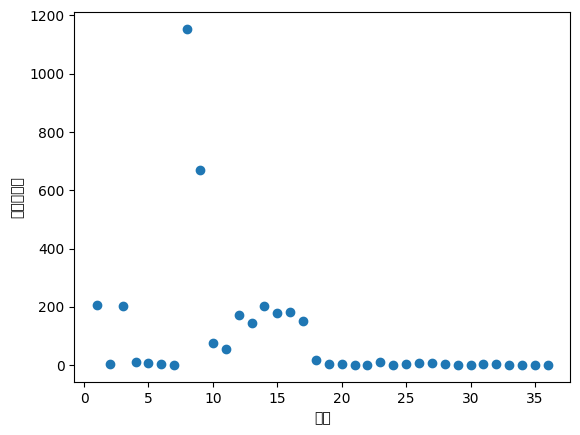

In [10]:
prediction_error = np.abs(np.asarray(onset_list_predict) - np.asarray(onset_list))

# 将误差绘制为散点图
plt.figure(1)
plt.scatter(np.arange(1, len(prediction_error)+1),prediction_error)
#plt.hlines(10, 0, len(prediction_error)+1, colors='red')
plt.ylabel('误差（秒）')
plt.xlabel('患者')
plt.show()

## 癫痫发作分类/检测
作为示例，我们在这里还展示了一个"学习"模型，用于将信号分类为"包含发作"/"不包含发作"，该模型仅基于单个特征和阈值进行这种区分。
该模型用于说明如何在训练期间学习参数，以及如何在预测期间重新加载模型。此外，分类的F1分数也作为排名中的附加分数显示。

In [11]:
# 癫痫发作检测

feature = []
label = []

for i,_id in enumerate(ids):
    _fs = sampling_frequencies[i]
    _eeg_signals = data[i]
    _eeg_label = eeg_labels[i]
    label.append(_eeg_label[0])
    # 计算导联
    _montage, _montage_data, _is_missing = get_3montages(channels[i], _eeg_signals)
    signal_std = np.zeros(len(_montage))
    for j, signal_name in enumerate(_montage):
        # 提取EEG的第一个导联
        signal = _montage_data[j]
        # 应用陷波滤波器来抑制工频噪声
        signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
        # 应用0.5Hz到70Hz的带通滤波器来过滤信号中的噪声
        signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
        
        # 通常在癫痫发作期间EEG中会出现更高的标准差
        signal_std[j] = np.std(signal_filter)

    # 只考虑具有最大标准差的通道
    signal_std_max = signal_std.max()
    feature.append(signal_std_max)

我们可以通过两个类别特征的直方图来可视化特征的判别能力。

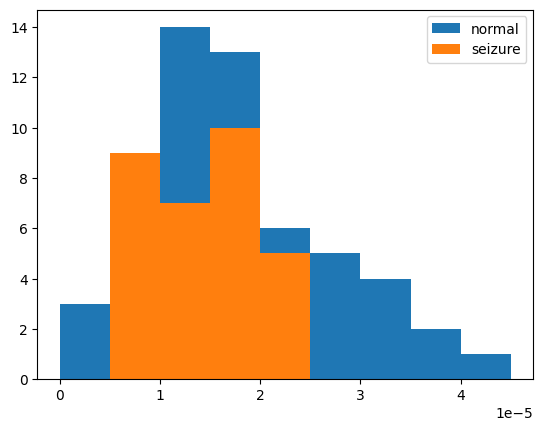

In [ ]:
# 特征分布的可视化
# 定义特征和标签数组
X = np.array(feature)
Y = np.array(label)
# 绘制正常和发作特征的直方图
bins = np.arange(0,0.00005,0.000005)
plt.figure()
plt.hist(X[(Y==0)], bins=bins)
plt.hist(X[Y==1],bins=bins)
plt.legend(['正常','发作'])

通过参数扫描计算最佳阈值

In [13]:
best_f1 = 0
th_opt = 0
for th in np.arange(X.min(),X.max(),(X.max()-X.min())/1e5):
    pred = X>th
    TP = np.sum((pred==Y) & (Y==1))
    FP = np.sum((pred==1) & (Y==0))
    FN = np.sum((pred==0) & (Y==1))
    F1 = 2*TP/(2*TP+FP+FN)  
    if F1 >best_f1:
        th_opt = th
        best_f1 = F1

In [14]:
print('最优阈值是', th_opt,'，训练数据上的F1分数为',best_f1)

最优阈值是 4.925801507306835e-06 ，训练数据上的F1分数为 0.5413533834586466
